In [1]:
import os
import ast
import sqlite3
import openai
import pandas as pd
from pathlib import Path, PosixPath
from typing import NamedTuple
from tabulate import tabulate
from dotenv import dotenv_values
from langchain import OpenAI, SQLDatabase, PromptTemplate, LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.llms import OpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough  # Try without .passthrough
from langchain_experimental.sql import SQLDatabaseChain

# from langchain.utilities import SQLDatabase

In [2]:
class ColumnDetail(NamedTuple):
    """
    Represents the details of a column in a dataset.

    Attributes:
        name (str): The name of the column.
        type (str): The data type of the column.
        values (list[str | int | float]): The values present in the column.
    """

    name: str
    type: str
    values: list[str | int | float]

In [3]:
def get_env_values() -> dict[str, str | None]:
    """
    Get the environment variable values.

    Returns:
        dict[str, str | None]: A dictionary containing the environment variable values.
    """
    return dotenv_values()


env_values: dict[str, str | None] = get_env_values()


# NamedTuple type hint
class ParametersType(NamedTuple):
    """
    Represents the parameters for the script.

    Attributes:
        data_dir (PosixPath): Platform neutral pathlib PosixPath to data directory.
        acs_path (PosixPath): Platform neutral pathlib PosixPath to ACS data.
        db_path (PosixPath): Platform neutral pathlib PosixPath to SQLite3 database.
        db_connection (sqlite3.Connection): SQLite3 database connection.
        openai_api_key (str): OpenAI API key.
        huggingfacehub_api_token (str): HuggingFace API token.
    """

    data_dir: PosixPath
    acs_path: PosixPath
    db_path: PosixPath
    db_connection: sqlite3.Connection
    openai_api_key: str
    huggingfacehub_api_token: str


Parameters: ParametersType = ParametersType(
    data_dir=Path.cwd() / "Data",
    acs_path=Path.cwd() / "Data/ACS_2012_21.csv",
    db_path=Path.cwd() / "Data/data.sqlite3",
    db_connection=sqlite3.connect(Path.cwd() / "Data/data.sqlite3"),
    openai_api_key=env_values["OPENAI_API_KEY"],
    huggingfacehub_api_token=env_values["HUGGINGFACEHUB_API_TOKEN"],
)

In [4]:
class DatabaseInfoExtractor:
    """
    A class for extracting information about tables and columns from a SQLite database.

    Attributes:
    - db_path (str): The path to the SQLite database file.
    - conn (sqlite3.Connection): The connection object to the database.
    - cursor (sqlite3.Cursor): The cursor object for executing SQL queries.

    Methods:
    - __init__(self, db_path: PosixPath) -> None: Initializes the DatabaseInfoExtractor object.
    - extract_info(self) -> dict[str, dict[str, list[str]]]: Returns a dictionary containing information about each table in the database.
    """

    def __init__(self, db_path: PosixPath) -> None:
        """
        Initializes the DatabaseInfoExtractor object.

        Parameters:
        - db_path (str): The path to the SQLite database file.
        """
        self.db_path = db_path
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()

    def extract_info(self) -> dict[str, dict[str, list[str]]]:
        """
        Extracts information about tables and columns from the SQLite database.

        Returns:
        - dict[str, dict[str, list[str]]]: A dictionary containing information about each table in the database.
        """
        # Dictionary to store table information
        tables: dict[str, str] = {}

        # Get the names of all tables in the database
        self.cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        table_names: list[str] = [row[0] for row in self.cursor.fetchall()]

        # Iterate over each table
        for table_name in table_names:
            columns: list[str] = []
            column_types: list[str] = []

            # Get the columns and their types for the current table
            self.cursor.execute(f"PRAGMA table_info({table_name})")
            for row in self.cursor.fetchall():
                columns.append(row[1])
                column_types.append(row[2])

            # Store the columns and their types in the tables dictionary
            tables[table_name] = {"columns": columns, "column_types": column_types}

            # Fetch the first five records from the table
            self.cursor.execute(f"SELECT * FROM {table_name} LIMIT 5;")
            records: list[tuple] = self.cursor.fetchall()
            tables[table_name]["records"] = records

        return tables

In [5]:
class AnswerGenerator:
    def __init__(
        self, question: str, table_text: str, conn: sqlite3.Connection
    ) -> None:
        """
        Initialize the AnswerGenerator class.

        Parameters:
            question (str): The question to be answered.
            table_text (str): The table information.
            conn (sqlite3.Connection): The SQLite database connection.
        """
        self.question = question
        self.table_text = table_text
        self.conn = conn

    def generate_sql_prompt_v1(self) -> str:
        """
        Generate a SQL prompt for version 1.

        Returns:
            str: The SQL prompt.
        """
        return f"""
Please return a syntactically correct SQLite query answering the following question:

{self.question}

Using the table information below:

{self.table_text}

Always quote the table columns used in the query.

If you are not able to exactly answer the question, please return the following message:

I am not able to answer the question exactly.
        """

    def generate_sql_prompt_v2(self) -> str:
        """
        Generate a SQL prompt for version 2.

        Returns:
            str: The SQL prompt.
        """
        return f"""
Please return a syntactically correct SQLite query, always quote the columns used in the query, answering the following question:

{self.question}

Using the table information below:

{self.table_text}
        """

    def dataframe_to_text_table(self, df: pd.DataFrame, tablefmt: str = "plain") -> str:
        """
        Convert a pandas DataFrame into a formatted text table.

        Parameters:
            df (pd.DataFrame): The DataFrame to be converted.
            tablefmt (str, optional): The table format. Defaults to "plain".

        Returns:
            str: The formatted text table.
        """
        return tabulate(df, headers="keys", tablefmt=tablefmt, showindex=False)

    def clean_up_result(self, result: str, sql: str) -> str:
        """
        Clean up the result and SQL query for readability.

        Parameters:
            result (str): The result to be cleaned up.
            sql (str): The SQL query.

        Returns:
            str: The cleaned up result.
        """
        return f"""
Please put the following result in readable format:

{result}

It was generated by this SQL query:

{sql}
        """

    def answer_question(self):
        """
        Answer the question by generating SQL prompts, executing the query, and cleaning up the result.
        """
        # Generate SQL prompt
        self.sql_prompt = self.generate_sql_prompt_v1()

        # Generate SQL query
        self.sql = llm(self.sql_prompt)

        # Execute the query and get the result as a DataFrame
        self.df_result: pd.DataFrame = pd.read_sql(self.sql, self.conn)

        # Convert the DataFrame to a formatted text table
        self.df_text: str = self.dataframe_to_text_table(self.df_result)

        # Clean up the result and SQL query for readability
        self.clean_up_result_prompt = self.clean_up_result(self.df_text, self.sql)

        # Clean the result
        self.cleaned_result = llm(self.clean_up_result_prompt)

In [6]:
class PythonPlotCode:
    """
    A class that generates Python code for plotting a Pandas DataFrame.

    Args:
        df_result (pd.DataFrame): The Pandas DataFrame to be plotted.
        df_text (str): Tabular text version of the pandas DataFrame.
        question (str): The question the data answers.
        sql (str): The SQL query used to generate the data.

    Attributes:
        df_result (pd.DataFrame): The Pandas DataFrame to be plotted.
        df_text (str):  Tabular text version of the pandas DataFrame.
        question (str): The question the data answers.
        sql (str): The SQL query used to generate the data.
        df_name (str): The name of the DataFrame.
        prompt (str): The prompt for generating the Python code.
        python_code (str): The generated Python code for plotting.

    Methods:
        plot(): Plot the DataFrame if there is more than one data point.

    """

    def __init__(
        self, df_result: pd.DataFrame, df_text: str, question: str, sql: str
    ) -> None:
        self.df_result: pd.DataFrame = df_result
        self.df_text: str = df_text
        self.question: str = question
        self.sql: str = sql
        self.df_name: str = "self.df_result"
        self.prompt: str = f"""
Please return Python code to plot Pandas DataFrame {self.df_name}, containing this:

{self.df_text}

The code should not create a new data frame but use the existing Pandas DataFrame, {self.df_name}.

The data answers this question:

{self.question}

Which was generated by this SQL query:

{self.sql}
        """
        self.python_code: str = llm(self.prompt)

    def plot(self):
        """
        Plot the DataFrame if there is more than one data point.

        Raises:
            Exception: If there is an error in the Python plot code.

        """
        self.more_than_one_data_point: bool = sum(self.df_result.shape) > 2
        self.plot_code_error: bool | str = False
        try:
            # Plot if there is more than one data point
            if self.more_than_one_data_point:
                exec(self.python_code)
        except Exception as e:
            self.plot_code_error = f"Error in Python plot code: {e}"

In [7]:
class DatabaseInfoFormatter:
    """
    Class for formatting the database information for tabulation.
    """

    def __init__(self, db_info: dict[str, dict[str, list]]) -> None:
        self.db_info = db_info

    def col_details_to_named_tup(self, table_name: str) -> dict[int, ColumnDetail]:
        """
        Put the column detail into a NamedTuple.
        """
        values: list[str | int | float] = [
            [t[i] for t in self.db_info[table_name]["records"]]
            for i in range(len(self.db_info[table_name]["columns"]))
        ]

        col_details: list[tuple[str, str, list[str | int | float]]] = list(
            zip(
                self.db_info[table_name]["columns"],
                self.db_info[table_name]["column_types"],
                values,
            )
        )

        return {
            i: ColumnDetail(*col_detail) for i, col_detail in enumerate(col_details)
        }

    def fmt_df_info_for_tabulation(
        self,
    ) -> dict[str, list[str, str, str, list[str | int | float]]]:
        """
        Format the database information for tabulation.
        """
        table_summaries: dict[str, list[str, str, str, list[str | int | float]]] = {}

        for table_name, table_info in self.db_info.items():
            table_summary = []
            column_details: dict[int, ColumnDetail] = self.col_details_to_named_tup(
                table_name
            )

            for col_detail in column_details.values():
                table_summary.append(
                    [table_name, col_detail.name, col_detail.type, col_detail.values]
                )

            table_summaries[table_name] = table_summary

        return table_summaries

In [8]:
# Instantiate DatabaseInfoExtractor
db_info_extractor: DatabaseInfoExtractor = DatabaseInfoExtractor(Parameters.db_path)

In [9]:
# Extract information about the database
db_info: dict[str, dict[str, list[str]]] = db_info_extractor.extract_info()

In [10]:
# Format the database information for tabulate function
InfoFormatter: DatabaseInfoFormatter = DatabaseInfoFormatter(db_info)

table_summaries: dict[
    str, list[str, str, str, list[str | int | float]]
] = InfoFormatter.fmt_df_info_for_tabulation()

In [11]:
# Connect to the database
db_path: PosixPath = Parameters.db_path
conn: sqlite3.connect = sqlite3.connect(db_path)
cursor: sqlite3.Cursor = conn.cursor()

In [12]:
# LLM call Using LangChain
llm: OpenAI = OpenAI(
    model_name="text-davinci-003", openai_api_key=Parameters.openai_api_key
)

In [13]:
# Table headers for tabulation
table_headers: list[str] = [
    "Table Name",
    "Column Name",
    "Column Type",
    "First Five Column Values",
]

In [14]:
# Table text for ACS table
table_text: str = (
    tabulate(table_summaries["acs"], headers=table_headers, tablefmt="plain") + "\n"
)  # grid

In [15]:
# Create a question
question: str = "How many nine year olds were in Kentucky in 2020?"

# Instantiate AnswerGenerator with the question, table text, and database connection
Answer: AnswerGenerator = AnswerGenerator(question, table_text, conn)

# Answer the question by generating SQL prompts, executing the query, and cleaning up the result
Answer.answer_question()

# Print the SQL prompt, SQL query, DataFrame text, cleaned up result prompt, and cleaned result
print(Answer.sql_prompt)
print(Answer.sql)
print(Answer.df_text)
print(Answer.clean_up_result_prompt)
print(Answer.cleaned_result)

# Instantiate PythonPlotCode with the DataFrame result, DataFrame text, question, and SQL query
PlotCode: PythonPlotCode = PythonPlotCode(
    df_result=Answer.df_result,
    df_text=Answer.df_text,
    question=Answer.question,
    sql=Answer.sql,
)

# Print the prompt and generated Python code for plotting
print(PlotCode.prompt)
print(PlotCode.python_code)

# Plot the DataFrame if there is more than one data point
PlotCode.plot()

# Print whether there is more than one data point and any plot code error
print(PlotCode.more_than_one_data_point)
print(PlotCode.plot_code_error)


Please return a syntactically correct SQLite query answering the following question:

How many nine year olds were in Kentucky in 2020?

Using the table information below:

Table Name    Column Name                                                   Column Type    First Five Column Values
acs           Unnamed: 0                                                    INTEGER        [0, 1, 2, 3, 4]
acs           Geography                                                     TEXT           ['0400000US01', '0400000US01', '0400000US01', '0400000US01', '0400000US01']
acs           Geographic Area Name                                          TEXT           ['Alabama', 'Alabama', 'Alabama', 'Alabama', 'Alabama']
acs           Total population                                              INTEGER        [4777326, 4817678, 4799277, 4841164, 4830620]
acs           Male                                                          INTEGER        [2317520, 2336020, 2328592, 2346193, 2341093]
acs           F


Please return a syntactically correct SQLite query answering the following question:

How many nine year olds were in Kentucky by year?

Using the table information below:

Table Name    Column Name                                                   Column Type    First Five Column Values
acs           Unnamed: 0                                                    INTEGER        [0, 1, 2, 3, 4]
acs           Geography                                                     TEXT           ['0400000US01', '0400000US01', '0400000US01', '0400000US01', '0400000US01']
acs           Geographic Area Name                                          TEXT           ['Alabama', 'Alabama', 'Alabama', 'Alabama', 'Alabama']
acs           Total population                                              INTEGER        [4777326, 4817678, 4799277, 4841164, 4830620]
acs           Male                                                          INTEGER        [2317520, 2336020, 2328592, 2346193, 2341093]
acs           F

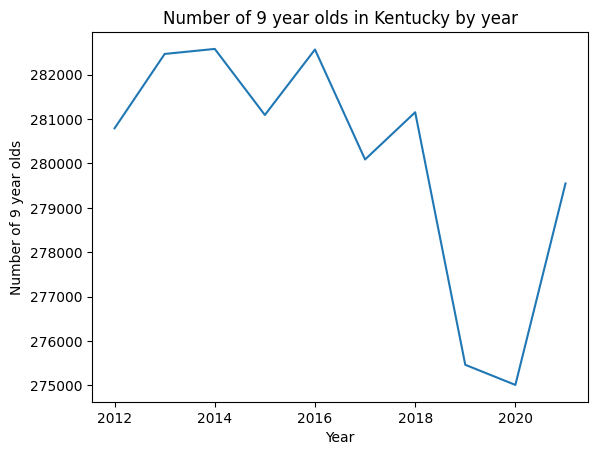

True
False


In [16]:
# Create a question
question: str = "How many nine year olds were in Kentucky by year?"

# Instantiate AnswerGenerator with the question, table text, and database connection
Answer: AnswerGenerator = AnswerGenerator(question, table_text, conn)

# Answer the question by generating SQL prompts, executing the query, and cleaning up the result
Answer.answer_question()

# Print the SQL prompt, SQL query, DataFrame text, cleaned up result prompt, and cleaned result
print(Answer.sql_prompt)
print(Answer.sql)
print(Answer.df_text)
print(Answer.clean_up_result_prompt)
print(Answer.cleaned_result)

# Instantiate PythonPlotCode with the DataFrame result, DataFrame text, question, and SQL query
PlotCode: PythonPlotCode = PythonPlotCode(
    df_result=Answer.df_result,
    df_text=Answer.df_text,
    question=Answer.question,
    sql=Answer.sql,
)

# Print the prompt and generated Python code for plotting
print(PlotCode.prompt)
print(PlotCode.python_code)

# Plot the DataFrame if there is more than one data point
PlotCode.plot()

# Print whether there is more than one data point and any plot code error
print(PlotCode.more_than_one_data_point)
print(PlotCode.plot_code_error)

In [ ]:
question: str = "How many nine year olds were in Kentucky in 2020?"

table_feature: str = (
    tabulate(table_summaries["acs"], headers=table_headers, tablefmt="plain") + "\n"
)  # grid

id_data_prompt: str = f"""
What columns in the table below:

{table_feature}

Can be used to answer the following question:

{question}
"""

print(id_data_prompt)

In [ ]:
result: str = llm(id_data_prompt)

print(
    id_data_prompt,
    result,
    table_summaries["acs"][0][0],
    table_summaries["acs"][0][1],
    sep=" - ",
)

In [ ]:
len(table_summaries["acs"])

In [ ]:
question: str = "How many nine year olds were in Kentucky in 2020?"

for i in range(len(table_summaries["acs"])):
    table_feature: str = (
        tabulate([table_summaries["acs"][i]], headers=table_headers, tablefmt="plain")
        + "\n"
    )  # grid

    id_data_prompt: str = f"""
    Is the following column:

    {table_feature}

    A candidate to help answer the following question:

    {question}

    Your answer should only be exactly one of the following:
    1) yes,
    2) no, or
    3) maybe
    Ommit punctuation from your response and return it in lower case.
    """

    result: str = llm(id_data_prompt)

    print(result, table_summaries["acs"][i][0], table_summaries["acs"][i][1], sep=" - ")

In [ ]:
question: str = "How many nine year olds were in Kentucky in 2020?"

for i in range(len(table_summaries["acs"])):
    table_feature: str = (
        tabulate([table_summaries["acs"][i]], headers=table_headers, tablefmt="plain")
        + "\n"
    )  # grid

    id_data_prompt: str = f"""
    Can the following column:

    {table_feature}

    Be used in a SQLite query to help answer the following question:

    {question}

    Your answer should only be exactly one of the following:
    1) yes,
    2) no, or
    3) maybe
    Ommit punctuation from your response and return it in lower case.
    """

    result: str = llm(id_data_prompt)

    print(result, table_summaries["acs"][i][0], table_summaries["acs"][i][1], sep=" - ")

# ACS Data

In [ ]:
acs_df: pd.DataFrame = pd.read_csv(Parameters.acs_path)
acs_df.drop(columns=["Unnamed: 0"], inplace=True)
display(acs_df.info())
display(acs_df.head())

In [ ]:
"""
SELECT SUM(Under 5 years + 5 to 9 years) AS nine_year_olds
FROM acs
WHERE Geography LIKE '0400000US21'
AND YEAR=2020;
"""

(
    acs_df.query("Geography == '0400000US21' and YEAR == 2020")["Under 5 years"].sum()
    + acs_df.query("Geography == '0400000US21' and YEAR == 2020")["5 to 9 years"].sum()
)

In [ ]:
acs_df[acs_df["Geography"] == "0400000US21"]["Geographic Area Name"].unique()

# List all tables in SQLite database

In [ ]:
cursor = Parameters.db_connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables: list[tuple] = cursor.fetchall()
tables

# Test OpenAI API Key

In [ ]:
"""
Please provide python code to ask openai a question and retrieve the answer

To ask OpenAI a question and retrieve the answer, you can use the OpenAI API.
Here's an example Python code that demonstrates how to do this using the openai package:

In this example, you need to replace "YOUR_API_KEY" with your actual API key,
which you can obtain by signing up for OpenAI's API at https://beta.openai.com/signup/.

The ask_openai function takes three parameters: the question you want to ask,
the name of the OpenAI model you want to use (e.g., "davinci" or "curie"),
and the max_length of the generated answer (in number of tokens).

The function sends a request to the OpenAI API using the openai.Completion.create method,
which takes the engine, prompt, and max_tokens as parameters. The response is a list of
completions (i.e., possible answers), and we take the first one (which is usually the most likely answer)
and return it as a string.
"""

openai.api_key = Parameters.openai_api_key  # "YOUR_API_KEY" # replace with your API key


def ask_openai(question, model, max_length):
    prompt = f"Q: {question}\nA:"
    completions = openai.Completion.create(
        engine=model, prompt=prompt, max_tokens=max_length
    )
    answer = completions.choices[0].text.strip()
    return answer


# Example usage
question = "What is the capital of France?"
model = "davinci"
max_length = 100
answer = ask_openai(question, model, max_length)
print(answer)

# [LangChain](https://pypi.org/project/langchain/)
https://coinsbench.com/chat-with-your-databases-using-langchain-bb7d31ed2e76  
https://medium.com/@hannanmentor/python-custom-chatgpt-with-your-own-data-f307635dd5bd  

## Check that LangChain works

In [ ]:
# Simple LLM call Using LangChain
llm = OpenAI(model_name="text-davinci-003", openai_api_key=Parameters.openai_api_key)
question = "Which language is used to create chatgpt ?"
print(question, llm(question))

## Prompt template

In [ ]:
# Creating a prompt template and running the LLM chain
template = "What are the top {n} resources to learn {language} programming?"
prompt = PromptTemplate(template=template, input_variables=["n", "language"])
chain = LLMChain(llm=llm, prompt=prompt)
input_ = {"n": 3, "language": "Python"}
print(chain.run(input_))

In [ ]:
type(prompt)

In [ ]:
# SQLDatabase.create_table_from_df(df=acs_df, table_name="acs", db_connection=Parameters.db_connection)  # Create table from dataframe

In [ ]:
# Use LangChain to answers quetions using a SQLite3 database
llm = OpenAI(model_name="text-davinci-003", openai_api_key=Parameters.openai_api_key)
dburi = "sqlite:///Data/acs.sqlite3"
db = SQLDatabase.from_uri(dburi)
question = "What is the population of Kentucky?"
print(question, llm(question, db))

In [ ]:
template = """Based on the table schema below, write a SQL query that would answer the user's question:
{schema}

Question: {question}
SQL Query:"""
prompt = ChatPromptTemplate.from_template(template)

In [ ]:
type(prompt)

In [ ]:
print(prompt)

In [ ]:
# db = SQLDatabase.from_uri("sqlite:///Data/data.sqlite3")
db = SQLDatabase.from_uri("sqlite:///Data/acs.sqlite3")

In [ ]:
result = db.run("SELECT * FROM acs LIMIT 5")
result

In [ ]:
result: list[tuple] = ast.literal_eval(db.run("SELECT * FROM acs LIMIT 5"))
print(result)

In [ ]:
def get_schema(_):
    return db.get_table_info()

In [ ]:
def run_query(query):
    return db.run(query)

In [ ]:
model = ChatOpenAI()

sql_response = (
    RunnablePassthrough.assign(schema=get_schema)
    | prompt
    | model.bind(stop=["\nSQLResult:"])
    | StrOutputParser()
)

In [ ]:
sql_response.invoke({"question": "How many geographic areas are in the acs table?"})

In [ ]:
print(get_schema(_))

In [ ]:
type(sql_response)

In [ ]:
sql_response

In [ ]:
openai.api_key = Parameters.openai_api_key


def count_tokens(prompt):
    response = openai.Completion.create(
        engine="davinci",
        prompt=prompt,
        max_tokens=0,
        n=1,
        stop=None,
        temperature=0.0,
        logprobs=0,
        echo=True,
    )
    return len(response.choices[0].text.split())


prompt = "This is a prompt to count tokens."
print(count_tokens(prompt))  # Output: 6

In [ ]:
prompt = get_schema(_)
print(count_tokens(prompt))

In [ ]:
# setup llm
llm = ChatOpenAI()  # OpenAI(temperature=0, openai_api_key=Parameters.openai_api_key)

dburi = "sqlite:///Data/acs.sqlite3"
db = SQLDatabase.from_uri(dburi)

# Create db chain
QUERY = """
Given an input question: first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

Use the following format:
Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result of the SQLQuery
Answer: Final answer here

{question}
"""

# Setup the database chain
db_chain = SQLDatabaseChain.from_llm(llm=llm, db=db, verbose=True)


def get_prompt():
    print("Type 'exit' to quit")

    while True:
        prompt = input("Enter a prompt: ")

        if prompt.lower() == "exit":
            print("Exiting...")
            break
        else:
            try:
                question = QUERY.format(question=prompt)
                print(db_chain.run(question))
            except Exception as e:
                print(e)


get_prompt()

In [ ]:
template = """Based on the table schema below, write a SQL query that would answer the user's question:
{schema}

Question: {question}
SQL Query:"""
prompt = ChatPromptTemplate.from_template(template)

In [ ]:
model = ChatOpenAI()

sql_response = (
    RunnablePassthrough.assign(schema=get_schema)
    | prompt
    | model.bind(stop=["\nSQLResult:"])
    | StrOutputParser()
)

In [ ]:
sql_response.invoke({"question": "How many geographic areas are in the acs table?"})

In [ ]:
# setup llm
llm = ChatOpenAI()  # OpenAI(temperature=0, openai_api_key=Parameters.openai_api_key)

dburi = "sqlite:///Data/acs.sqlite3"
db = SQLDatabase.from_uri(dburi)

# Create db chain
QUERY = """
Given an input question: first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

Use the following format:
Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result of the SQLQuery
Answer: Final answer here

{question}
"""

# Setup the database chain
db_chain = SQLDatabaseChain.from_llm(llm=llm, db=db, verbose=True)

print("Type 'exit' to quit")

prompt = input("Enter a prompt: ")

if prompt.lower() == "exit":
    print("Exiting...")
else:
    try:
        sql_response.invoke({"question": prompt})
        question = sql_response  # prompt  # QUERY.format(question=prompt)
        print(db_chain.run(question))
    except Exception as e:
        print(e)

In [ ]:
# How many nine year olds were in Kentucky in 2020

In [ ]:
for k, v in db_chain.dict()["llm_chain"]["prompt"].items():
    print(k)
    print(v)
    print()